In [421]:
# step 1, get a random epsilon machine
# Sarah says EMLibrary folder has the topologies
import os
%load_ext autoreload
%autoreload 2

EM_topology_dir = os.path.join(os.getcwd(), 'EMLibrary')
print(EM_topology_dir)

# the topologies are *.hs

import glob
topologies = glob.glob(os.path.join(EM_topology_dir, '*.hs'))
print(topologies)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
c:\Users\adamimos\Documents\GitHub\epsilon-transformers\EMLibrary
['c:\\Users\\adamimos\\Documents\\GitHub\\epsilon-transformers\\EMLibrary\\1.hs', 'c:\\Users\\adamimos\\Documents\\GitHub\\epsilon-transformers\\EMLibrary\\2.hs', 'c:\\Users\\adamimos\\Documents\\GitHub\\epsilon-transformers\\EMLibrary\\3.hs', 'c:\\Users\\adamimos\\Documents\\GitHub\\epsilon-transformers\\EMLibrary\\4.hs', 'c:\\Users\\adamimos\\Documents\\GitHub\\epsilon-transformers\\EMLibrary\\5.hs', 'c:\\Users\\adamimos\\Documents\\GitHub\\epsilon-transformers\\EMLibrary\\6.hs']


In [422]:
def rate_distortion(p, beta, tol=1e-6, max_iter=5000):
    """
    Calculate the rate-distortion function for a given joint probability distribution p and a beta value.

    Args:
    p: Joint probability distribution.
    beta: Beta value, which can be interpreted as the inverse temperature in statistical physics.
    tol: Tolerance for convergence. If the change in marginal_pXhat and conditional_pXhat_given_S is less than tol,
         the function will stop iterating and return the current rate and distortion.
    max_iter: Maximum number of iterations.

    Returns:
    R: The rate value in the rate-distortion function.
    D: The distortion value in the rate-distortion function.
    """
    
    # Calculate the marginal probabilities of X and S
    marginal_pX = np.sum(p, 0)
    marginal_pS = np.sum(p, 1)

    # Calculate conditional probability of X given S
    conditional_pX_given_S = np.dot(np.diag(1 / marginal_pS), p)

    # Distortion matrix is equal to the conditional probability of X given S
    distortion_matrix = conditional_pX_given_S

    # Initialize the conditional probability of Xhat given S randomly
    initial_conditional_pXhat_given_S0 = np.random.uniform(size=len(marginal_pS))
    conditional_pXhat_given_S = np.vstack([initial_conditional_pXhat_given_S0, 1 - initial_conditional_pXhat_given_S0]).T

    # Calculate the marginal probability of Xhat
    marginal_pXhat = np.dot(conditional_pXhat_given_S.T, marginal_pS)

    # Iterate to refine the conditional probability of Xhat given S and marginal probability of Xhat
    for _ in range(max_iter):
        # Calculate new estimates
        log_conditional_pXhat_given_S = np.meshgrid(np.log(marginal_pXhat), np.ones(len(marginal_pS)))[0] + beta * distortion_matrix
        new_conditional_pXhat_given_S = np.exp(log_conditional_pXhat_given_S)
        normalization_constants = np.sum(new_conditional_pXhat_given_S, 1)
        new_conditional_pXhat_given_S = np.dot(np.diag(1 / normalization_constants), new_conditional_pXhat_given_S)
        new_marginal_pXhat = np.dot(new_conditional_pXhat_given_S.T, marginal_pS)
        
        # Check for convergence
        if np.allclose(marginal_pXhat, new_marginal_pXhat, atol=tol) and np.allclose(conditional_pXhat_given_S, new_conditional_pXhat_given_S, atol=tol):
            # print('convergence took {} iterations'.format(_))
            break
        
        # Update estimates
        marginal_pXhat = new_marginal_pXhat
        conditional_pXhat_given_S = new_conditional_pXhat_given_S

    # Calculate the rate value R in the rate-distortion function
    R = -np.nansum(marginal_pXhat * np.log(marginal_pXhat)) + np.dot(marginal_pS, np.nansum(conditional_pXhat_given_S * np.log(conditional_pXhat_given_S), 1))

    # Calculate the distortion value D in the rate-distortion function
    D = np.dot(marginal_pS, np.sum(conditional_pXhat_given_S * conditional_pX_given_S, 1))

    return R, D



In [423]:
def simulate_FSM(encoded_fsm, time_steps, seed=None):
    """
    Simulate a finite state machine (FSM) for a given number of time steps.

    Args:
    encoded_fsm: A string that encodes the structure of the FSM.
    time_steps: The number of time steps for the simulation.

    Returns:
    xs: The observations during the simulation.
    past_states: The past states during the simulation.
    betas: A set of beta values used to calculate the rate-distortion function.
    rate: The rate values in the rate-distortion function.
    distortion: The distortion values in the rate-distortion function.
    entropy_rate: The entropy rate of the source (a measure of randomness).
    statistical_complexity: The statistical complexity (a measure of structure).
    emmision_0_probs: The probabilities of emitting each observation from each state.
    """

    if seed is not None:
        np.random.seed(seed)

    # Remove the first 3 characters and the last character from the encoded FSM
    encoded_fsm = encoded_fsm[3:-1]

    # Find the position of the first ']' character
    pos = encoded_fsm.find(']')

    # The number of states is given by the character before the first ']'
    num_states = int(encoded_fsm[pos-1])
    states = np.arange(num_states)

    # The FSM has 2 possible observations
    observations = np.arange(2)

    # The rest of the FSM encoding starts 3 characters after the first ']' and ends 'pos' characters from the end
    encoded_fsm = encoded_fsm[pos+3:-pos-3]

    # Initialize the transition function as an empty dictionary
    transition_function = {}

    # Parse the FSM encoding to fill in the transition function
    while len(encoded_fsm) >= 7:
        transition = encoded_fsm[:7]
        transition_function[str(int(transition[1])-1) + transition[3]] = int(transition[5]) - 1

        # Remove the transition we just processed from the FSM encoding
        if len(encoded_fsm) > 8:
            encoded_fsm = encoded_fsm[8:]
        else:
            encoded_fsm = []

    # Initialize the emission probabilities as zeros
    emmision_0_probs = np.zeros(num_states)

    # Choose random probabilities for emissions
    for state in states:
        if str(state) + '0' in transition_function:
            if str(state) + '1' in transition_function:
                emmision_0_probs[state] = np.random.uniform()
            else:
                # If the state can only transition to 0, set the emission probability to 1
                emmision_0_probs[state] = 1
        else:
            # If the state cannot transition, set the emission probability to 0
            emmision_0_probs[state] = 0

    # Run the simulation
    current_state = np.random.randint(num_states)
    past_states = [current_state]
    xs = []
    for _ in range(time_steps):
        x = np.random.choice([0, 1], p=[emmision_0_probs[current_state], 1 - emmision_0_probs[current_state]])
        xs.append(x)
        current_state = transition_function[str(current_state) + str(x)]
        past_states.append(current_state)
    past_states = past_states[:-1]

    # Calculate joint probability distribution and transition matrix
    joint_prob_dist = np.zeros([num_states, 2])
    transition_matrix = np.zeros([num_states, num_states])
    for key in transition_function.keys():
        from_state = int(key[0])
        to_state = transition_function[key]
        if key[1] == '0':
            transition_matrix[to_state, from_state] += emmision_0_probs[from_state]
        else:
            transition_matrix[to_state, from_state] += 1 - emmision_0_probs[from_state]

    # Calculate the steady state distribution
    eigenvalues, eigenvectors = LA.eig(transition_matrix)
    steady_state_indices = np.abs(eigenvalues - 1) < 1e-10
    steady_state_distribution = eigenvectors[:, steady_state_indices]
    steady_state_distribution /= np.sum(steady_state_distribution)

    # Calculate joint probability distribution
    for state in states:
        if str(state) + '0' in transition_function:
            joint_prob_dist[state, 0] = emmision_0_probs[state] * steady_state_distribution[state][0]
        if str(state) + '1' in transition_function:
            joint_prob_dist[state, 1] = (1 - emmision_0_probs[state]) * steady_state_distribution[state][0]

    # Calculate rate-distortion function for a range of beta values
    betas = np.linspace(0, 500, 1000)
    rate = []
    distortion = []
    for beta in betas:
        r, d = rate_distortion(joint_prob_dist, beta)
        rate.append(r)
        distortion.append(d)

    betas = np.hstack([betas, np.inf])

    # Calculate entropy rate and statistical complexity
    p0 = 0
    accuracy = 0
    for i in range(num_states):
        accuracy += steady_state_distribution[i] * np.max([emmision_0_probs[i], 1 - emmision_0_probs[i]])
        if emmision_0_probs[i] > 0.5:
            p0 += steady_state_distribution[i]
    p1 = 1 - p0
    
    entropy = -p0 * np.log(p0) if p0 != 0 else 0
    entropy -= p1 * np.log(p1) if p1 != 0 else 0

    rate.append(entropy)
    distortion.append(accuracy)

    entropy_rate = -np.nansum(steady_state_distribution * np.log(steady_state_distribution))
    complexities = np.zeros_like(emmision_0_probs)
    mask = emmision_0_probs != 0
    complexities[mask] = -emmision_0_probs[mask] * np.log(emmision_0_probs[mask])
    mask = emmision_0_probs != 1
    complexities[mask] -= (1 - emmision_0_probs[mask]) * np.log(1 - emmision_0_probs[mask])
    statistical_complexity = np.dot(complexities, steady_state_distribution)

    return xs, past_states, betas, rate, distortion, entropy_rate, statistical_complexity, emmision_0_probs


## .hs File Structure for Finite State Machine (FSM) Definitions

Each line in a .hs file defines a separate Finite State Machine (FSM). The structure of each line is as follows:

`Fa [States] [(Transition 1), (Transition 2), ...] [States]`

Here's what each part of the line represents:

**Fa**: Marker indicating the start of a new FSM definition.

**[States]**: A list of integers that represent the states in the FSM.

**[(Transition 1), (Transition 2), ...]**: A list of tuples. Each tuple represents a transition in the FSM. Each transition tuple is formatted as (S, X, S'), where:

* S is the current state.
* X is the output or emission.
* S' is the next state after the transition.

**[States]**: This list appears again at the end of each line. Its purpose is unclear from the provided Python code and might be specific to the context in which these FSMs are used.

Each state and output is represented as an integer. The transitions in the FSM are deterministic, meaning each state and output pair maps to exactly one next state.

  0%|          | 0/78 [00:00<?, ?it/s]

C:\Users\adamimos\AppData\Local\Temp\ipykernel_20600\4270520919.py:99: ComplexWarning: Casting complex values to real discards the imaginary part
  joint_prob_dist[state, 0] = emmision_0_probs[state] * steady_state_distribution[state][0]
C:\Users\adamimos\AppData\Local\Temp\ipykernel_20600\4270520919.py:101: ComplexWarning: Casting complex values to real discards the imaginary part
  joint_prob_dist[state, 1] = (1 - emmision_0_probs[state]) * steady_state_distribution[state][0]


(1.0986122886681096-0j) [0.+0.j] [1. 1. 0.]
(1.0986122886681096-0j) [0.22831045+0.j] [1.        1.        0.4359949]
(1.0986122886681096-0j) [0.+0.j] [1. 0. 0.]
(1.0986122886681096-0j) [0.04830659+0.j] [1.         0.         0.96702984]
(1.0986122886681096-0j) [0.17647303+0.j] [1.         0.22199317 0.        ]
(1.0986122886681096-0j) [0.32535508+0.j] [1.         0.89286015 0.33197981]
(1.0986122886681096-0j) [0.08988634+0.j] [0.         0.         0.07630829]
(1.0986122886681096-0j) [0.17319803+0.j] [0.         0.8734294  0.96854066]
(0.11339664488393077-0j) [0.05654071+0.j] [0.01037415 1.         1.        ]
(1.090735872967888-0j) [0.21146344+0.j] [0.77132064 1.         0.        ]
(0.761901581335864-0j) [0.35949436+0.j] [0.18026969 1.         0.01947524]
(0.7093805958333611-0j) [0.32855925+0.j] [0.15416284 0.         1.        ]
(1.0912378365392092-0j) [0.20732551+0.j] [0.77770241 0.         0.        ]
(1.0443921561520804-0j) [0.47731251+0.j] [0.51394334 0.         0.77316505]
(1.0

KeyboardInterrupt: 

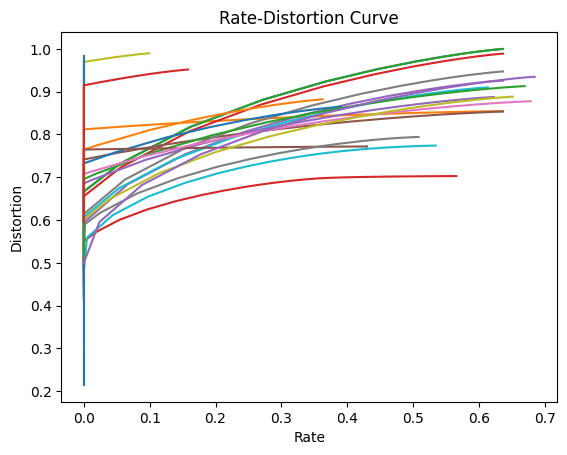

In [424]:
import numpy as np
import numpy.linalg as LA
import tqdm.notebook as tqdm

def read_and_simulate_fsm(filename, simulation_steps):
    """
    Read a file containing definitions of finite state machines (FSMs) 
    and simulate each FSM for a given number of steps.

    Args:
    filename: The name of the file containing the FSM definitions.
    simulation_steps: The number of steps for each simulation.

    Returns:
    No return value. The function prints the FSM definitions and the results of the simulations.
    """
    with open(filename, 'r') as file:
        n_lines = sum(1 for line in file)
        file.seek(0)
        for line_number, line in tqdm.tqdm(enumerate(file, start=1), total=n_lines):
            # print(f"Line {line_number}: {line}")
            
            try:
                xs, spasts, betas, Rs, Accs, Cmu, hmu, probsEmission = simulate_FSM(line, simulation_steps, seed=line_number)
                # You could add print statements or other code here to do something with the results of the simulation
                plt.plot(Rs[:-1], Accs[:-1])  # Accs for distortion (X-axis) and Rs for rate (Y-axis)
                plt.xlabel('Rate')
                plt.ylabel('Distortion')
                plt.title('Rate-Distortion Curve')
                            
            except Exception as e:
                print(f"An error occurred while simulating the FSM on line {line_number}: {e}")
            # print(f"Finished reading {line_number} lines from file {filename}.")
            print(Cmu, hmu, probsEmission)
    return xs, spasts, betas, Rs, Accs, Cmu, hmu, probsEmission
                
# Use the function to read and simulate the FSMs in a file
xs, spasts, betas, Rs, Accs, Cmu, hmu, probsEmission = read_and_simulate_fsm(topologies[2], 30000)


In [53]:
from typing import Dict, Tuple, List

def parse_encoded_fsm(encoded_fsm: str) -> Tuple[int, Dict[str, int]]:
    """
    Parse an encoded FSM string and return the number of states and the transition function.

    Args:
    encoded_fsm: A string that encodes the structure of the FSM.

    Returns:
    num_states: The number of states in the FSM.
    transition_function: The transition function as a dictionary.
    """
    num_states = int(encoded_fsm[encoded_fsm.find(']')-1])
    transition_function = {}
    for transition in encoded_fsm[encoded_fsm.find(']')+3:-4].split(' '):
        from_state = transition[1]
        to_state = transition[5]
        symbol = transition[3]
        transition_function[from_state + symbol] = int(to_state) - 1
    return num_states, transition_function


def initialize_emmision_0_probs(num_states: int, transition_function: Dict[str, int]) -> np.ndarray:
    """
    Initialize the emission probabilities for an FSM.

    Args:
    num_states: The number of states in the FSM.
    transition_function: The transition function as a dictionary.

    Returns:
    emmision_0_probs: The emission probabilities as a numpy array.
    """
    emmision_0_probs = np.zeros(num_states)
    for state in range(num_states):
        if str(state) + '0' in transition_function:
            if str(state) + '1' in transition_function:
                emmision_0_probs[state] = np.random.uniform()
            else:
                emmision_0_probs[state] = 1
        else:
            emmision_0_probs[state] = 0
    return emmision_0_probs


def simulate_time_steps(time_steps: int, current_state: int, transition_function: Dict[str, int], emmision_0_probs: np.ndarray) -> Tuple[List[int], List[int]]:
    """
    Simulate an FSM for a given number of time steps.

    Args:
    time_steps: The number of time steps for the simulation.
    current_state: The initial state for the simulation.
    transition_function: The transition function as a dictionary.
    emmision_0_probs: The emission probabilities as a numpy array.

    Returns:
    xs: The observations during the simulation.
    past_states: The past states during the simulation.
    """
    past_states = [current_state]
    xs = []
    for _ in range(time_steps):
        x = np.random.choice([0, 1], p=[emmision_0_probs[current_state], 1 - emmision_0_probs[current_state]])
        xs.append(x)
        current_state = transition_function[str(current_state) + str(x)]
        past_states.append(current_state)
    past_states = past_states[:-1]
    return xs, past_states


def calculate_joint_prob_dist(num_states: int, transition_function: Dict[str, int], emmision_0_probs: np.ndarray, steady_state_distribution: np.ndarray) -> np.ndarray:
    """
    Calculate the joint probability distribution for an FSM.

    Args:
    num_states: The number of states in the FSM.
    transition_function: The transition function as a dictionary.
    emmision_0_probs: The emission probabilities as a numpy array.
    steady_state_distribution: The steady state distribution as a numpy array.

    Returns:
    joint_prob_dist: The joint probability distribution as a numpy array.
    """
    joint_prob_dist = np.zeros([num_states, 2])
    for state in range(num_states):
        if str(state) + '0' in transition_function:
            joint_prob_dist[state, 0] = emmision_0_probs[state] * steady_state_distribution[state][0]
        if str(state) + '1' in transition_function:
            joint_prob_dist[state, 1] = (1 - emmision_0_probs[state]) * steady_state_distribution[state][0]
    return joint_prob_dist


def calculate_rate_distortion(joint_prob_dist: np.ndarray, beta: float) -> Tuple[float, float]:
    """
    Calculate the rate and distortion values for an FSM.

    Args:
    joint_prob_dist: The joint probability distribution as a numpy array.
    beta: The beta value to use in the calculation.

    Returns:
    rate: The rate value.
    distortion: The distortion value.
    """
    p0 = np.sum(joint_prob_dist[:, 0])
    p1 = np.sum(joint_prob_dist[:, 1])
    rate = beta * np.log2(p0 / p1)
    distortion = p0 * (np.log2(p0) - np.log2(joint_prob_dist[:, 0])) + p1 * (np.log2(p1) - np.log2(joint_prob_dist[:, 1]))
    distortion = np.sum(distortion)
    return rate, distortion


def calculate_entropy_rate(steady_state_distribution: np.ndarray) -> float:
    """
    Calculate the entropy rate of an FSM.

    Args:
    steady_state_distribution: The steady state distribution as a numpy array.

    Returns:
    entropy_rate: The entropy rate of the FSM.
    """
    entropy_rate = -np.nansum(steady_state_distribution * np.log(steady_state_distribution))
    return entropy_rate


def calculate_statistical_complexity(emmision_0_probs: np.ndarray, steady_state_distribution: np.ndarray) -> float:
    """
    Calculate the statistical complexity of an FSM.

    Args:
    emmision_0_probs: The emission probabilities as a numpy array.
    steady_state_distribution: The steady state distribution as a numpy array.

    Returns:
    statistical_complexity: The statistical complexity of the FSM.
    """
    complexities = np.zeros_like(emmision_0_probs)
    mask = emmision_0_probs != 0
    complexities[mask] = -emmision_0_probs[mask] * np.log(emmision_0_probs[mask])
    mask = emmision_0_probs != 1
    complexities[mask] -= (1 - emmision_0_probs[mask]) * np.log(1 - emmision_0_probs[mask])
    statistical_complexity = np.dot(complexities, steady_state_distribution)
    return statistical_complexity




In [54]:
def simulate_FSM(encoded_fsm: str, time_steps: int, beta: float) -> Dict[str, float]:
    """
    Simulate a finite state machine (FSM) and calculate various metrics related to the simulation.

    Args:
    encoded_fsm: A string that encodes the structure of the FSM.
    time_steps: The number of time steps to simulate.
    beta: The beta value to use in the rate-distortion calculation.

    Returns:
    A dictionary containing the following metrics:
    - joint_prob_dist: The joint probability distribution as a numpy array.
    - rate: The rate value.
    - distortion: The distortion value.
    - entropy_rate: The entropy rate of the FSM.
    - statistical_complexity: The statistical complexity of the FSM.
    """
    # Parse the encoded FSM string
    num_states, transition_function = parse_encoded_fsm(encoded_fsm)

    # Initialize the emission probabilities
    emmision_0_probs = initialize_emmision_0_probs(num_states, transition_function)

    # Simulate the FSM for the given number of time steps
    xs, past_states = simulate_time_steps(time_steps, 0, transition_function, emmision_0_probs)

    # Calculate the steady state distribution
    _, steady_state_distribution = np.linalg.eig(np.transpose(transition_matrix(transition_function)))

    # Calculate the joint probability distribution
    joint_prob_dist = calculate_joint_prob_dist(num_states, transition_function, emmision_0_probs, steady_state_distribution)

    # Calculate the rate and distortion values
    rate, distortion = calculate_rate_distortion(joint_prob_dist, beta)

    # Calculate the entropy rate
    entropy_rate = calculate_entropy_rate(steady_state_distribution)

    # Calculate the statistical complexity
    statistical_complexity = calculate_statistical_complexity(emmision_0_probs, steady_state_distribution)

    # Return the metrics as a dictionary
    return {
        'joint_prob_dist': joint_prob_dist,
        'rate': rate,
        'distortion': distortion,
        'entropy_rate': entropy_rate,
        'statistical_complexity': statistical_complexity
    }

# Attempt at making things cleaner

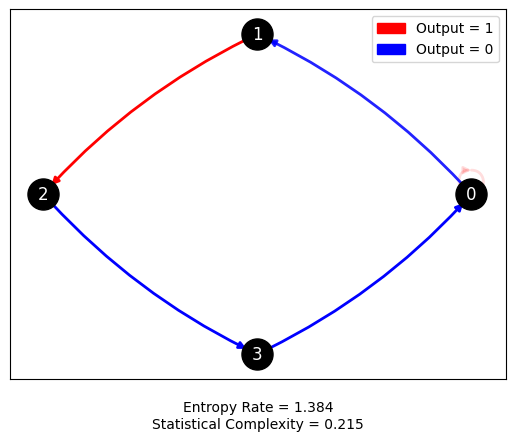

In [425]:
from typing import List, Dict
from pydantic import BaseModel, Field
import numpy as np
from numpy import linalg as LA
import networkx as nx
import matplotlib.pyplot as plt
# import mpatches
import matplotlib.patches as mpatches

class FiniteStateMachine(BaseModel):
    """
    A class to represent a Finite State Machine (FSM).

    Attributes
    ----------
    states : List[int]
        The states of the FSM.
    transition_function : Dict[str, int]
        The transition function of the FSM, represented as a dictionary mapping from
        state-action pairs to next states.
    emmision_0_probs : np.ndarray
        The probabilities of emitting 0 from each state.

    Methods
    -------
    simulate(time_steps: int, seed: int = None):
        Simulate the FSM for a given number of time steps.
    calculate_emmision_0_probs():
        Calculate the probabilities of emitting 0 for each state.
    calculate_joint_prob_dist_and_transition_matrix():
        Calculate the joint probability distribution and the transition matrix.
    calculate_entropy_and_complexity():
        Calculate the entropy rate and statistical complexity of the FSM.
    """

    states: List[int] = Field(...)
    transition_function: Dict[str, int] = Field(...)
    emmision_0_probs: np.ndarray = Field(default=None)
    transition_matrix: np.ndarray = Field(default=None)
    entropy_rate: float = Field(default=None)
    statistical_complexity: float = Field(default=None)
    transition_output_matrix: np.ndarray = Field(default=None)

    @classmethod
    def from_hs(cls, hs_line: str):
        # Remove the first 3 characters and the last character from the encoded FSM
        encoded_fsm = hs_line[3:-1]

        # Find the position of the first ']' character
        pos = encoded_fsm.find(']')

        # The number of states is given by the character before the first ']'
        num_states = int(encoded_fsm[pos-1])
        states = list(range(num_states))

        # The rest of the FSM encoding starts 3 characters after the first ']' and ends 'pos' characters from the end
        encoded_fsm = encoded_fsm[pos+3:-pos-3]

        # Initialize the transition function as an empty dictionary
        transition_function = {}

        # Parse the FSM encoding to fill in the transition function
        while len(encoded_fsm) >= 7:
            transition = encoded_fsm[:7]
            transition_function[str(int(transition[1])-1) + transition[3]] = int(transition[5]) - 1

            # Remove the transition we just processed from the FSM encoding
            if len(encoded_fsm) > 8:
                encoded_fsm = encoded_fsm[8:]
            else:
                encoded_fsm = []

        # Create a new instance of FiniteStateMachine, initialize emmission probabilities as zeros
        fsm = cls(states=states, transition_function=transition_function)

        # Calculate emission probabilities
        fsm.calculate_emmision_0_probs()

        # Calculate transition matrix
        fsm.calculate_transition_matrix()

        fsm.calculate_entropy_and_complexity()

        return fsm


    class Config:
        arbitrary_types_allowed = True

    def simulate(self, time_steps: int, seed: int = None):
        if seed is not None:
            np.random.seed(seed)

        # Run the simulation
        current_state = np.random.randint(len(self.states))
        past_states = [current_state]
        xs = []
        for _ in range(time_steps):
            x = np.random.choice([0, 1], p=[self.emmision_0_probs[current_state], 1 - self.emmision_0_probs[current_state]])
            xs.append(x)
            current_state = self.transition_function[str(current_state) + str(x)]
            past_states.append(current_state)
        past_states = past_states[:-1]

        return xs, past_states
    
    def calculate_transition_matrix(self):
        """
        Calculate the transition matrix for the FSM.
        """
        num_states = len(self.states)
        # Initialize the transition matrix and output matrix as zeros
        self.transition_matrix = np.zeros((num_states, num_states))
        self.transition_output_matrix = np.full((num_states, num_states), np.nan)

        # Fill the transition matrix and output matrix according to transition_function
        for key, value in self.transition_function.items():
            from_state = int(key[0])
            to_state = value
            output = int(key[1])
            
            if key[1] == '0':
                self.transition_matrix[to_state, from_state] += self.emmision_0_probs[from_state]
            else:
                self.transition_matrix[to_state, from_state] += 1 - self.emmision_0_probs[from_state]
            
            self.transition_output_matrix[to_state, from_state] = output


    def calculate_emmision_0_probs(self, seed: int = None):
        """
        Calculate the emission probabilities for each state in the FSM.
        """

        if seed is not None:
            np.random.seed(seed)

        # Initialize the emission probabilities as zeros
        self.emmision_0_probs = np.zeros(len(self.states))

        # Choose random probabilities for emissions
        for state in self.states:
            if str(state) + '0' in self.transition_function:
                if str(state) + '1' in self.transition_function:
                    self.emmision_0_probs[state] = np.random.uniform()
                else:
                    # If the state can only transition to 0, set the emission probability to 1
                    self.emmision_0_probs[state] = 1
            else:
                # If the state cannot transition, set the emission probability to 0
                self.emmision_0_probs[state] = 0

    def calculate_joint_prob_dist_and_transition_matrix(self):
        # Placeholder for joint probability distribution and transition matrix calculation logic
        pass

    def calculate_entropy_and_complexity(self, recalculate: bool = False):
            if self.entropy_rate is not None and self.statistical_complexity is not None and not recalculate:
                return self.entropy_rate, self.statistical_complexity

            # Calculate the steady state distribution
            eigenvalues, eigenvectors = LA.eig(self.transition_matrix)
            steady_state_indices = np.abs(eigenvalues - 1) < 1e-10
            steady_state_distribution = eigenvectors[:, steady_state_indices]
            steady_state_distribution /= np.sum(steady_state_distribution)

            # Calculate p0 and p1
            p0 = 0
            accuracy = 0
            for i in range(len(self.states)):
                accuracy += steady_state_distribution[i] * np.max([self.emmision_0_probs[i], 1 - self.emmision_0_probs[i]])
                if self.emmision_0_probs[i] > 0.5:
                    p0 += steady_state_distribution[i]
            p1 = 1 - p0

            # Calculate entropy rate
            entropy = -p0 * np.log(p0) if p0 != 0 else 0
            entropy -= p1 * np.log(p1) if p1 != 0 else 0
            self.entropy_rate = -np.nansum(steady_state_distribution * np.log(steady_state_distribution))

            # Calculate statistical complexity
            complexities = np.zeros_like(self.emmision_0_probs)
            mask = self.emmision_0_probs != 0
            complexities[mask] = -self.emmision_0_probs[mask] * np.log(self.emmision_0_probs[mask])
            mask = self.emmision_0_probs != 1
            complexities[mask] -= (1 - self.emmision_0_probs[mask]) * np.log(1 - self.emmision_0_probs[mask])
            self.statistical_complexity = np.dot(complexities, steady_state_distribution)

            def deal_with_complex_part(value):
                if np.iscomplex(value):
                    complex_part = np.imag(value)
                    if complex_part < 1e-10:
                        return np.squeeze(np.real(value))
                    else:
                        raise ValueError("value is complex")
                else:
                    return np.squeeze(np.real(value))
                
            self.entropy_rate = deal_with_complex_part(self.entropy_rate)
            self.statistical_complexity = deal_with_complex_part(self.statistical_complexity)

                
            return self.entropy_rate, self.statistical_complexity
    
    def plot_from_transition_matrix(self):
        matrix = self.transition_matrix
        G = nx.DiGraph()

        # Add nodes
        for i in range(len(matrix)):
            G.add_node(i)

        # Add edges
        for i in range(len(matrix)):
            for j in range(len(matrix[i])):
                if matrix[i][j] != 0:  # If there's a transition from i to j
                    output = self.transition_output_matrix[i][j]
                    G.add_edge(j,i, weight=matrix[i][j], label=output)

        # options for the layout are 'spring', 'spectral', 'random', 'circular', 'shell', 'kamada_kawai'
        #pos = nx.kamada_kawai_layout(G, scale=0.5)
        pos = nx.circular_layout(G)

        # Get edge weights and normalize for drawing
        weights = [G[u][v]['weight'] for u, v in G.edges()]

        # edge color is blue if output is 0, red if output is 1
        edge_colors = ['b' if G[u][v]['label'] == 0 else 'r' for u, v in G.edges()]

        # Plot nodes
        nx.draw_networkx_nodes(G, pos, node_color='k', node_size=500)
        nx.draw_networkx_labels(G, pos, font_color='white')

        # Plot edges with alpha values proportional to the weights
        for i in range(len(weights)):
            edge = list(G.edges())[i]
            nx.draw_networkx_edges(G, pos, edgelist=[edge], edge_color=edge_colors[i],
                                   width=2, alpha=weights[i], connectionstyle='arc3, rad=0.1')

        # add a key for the edge label colors
        red_patch = mpatches.Patch(color='red', label='Output = 1')
        blue_patch = mpatches.Patch(color='blue', label='Output = 0')
        plt.legend(handles=[red_patch, blue_patch])

        # if entropy rate and statistical complexity have been calculated, add them in the bottom right
        if self.entropy_rate is not None and self.statistical_complexity is not None:
            # convert to string with 3 decimal places, if theres a complex number just disregard the complex part
            entropy_rate = str(np.round(self.entropy_rate, 3)).replace('j', 'i')
            statistical_complexity = str(np.round(self.statistical_complexity, 3)).replace('j', 'i')
            text_string = 'Entropy Rate = ' + entropy_rate + '\nStatistical Complexity = ' + statistical_complexity
            plt.text(0.5, -0.1, text_string, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.show()


    def compute_block_entropy(self, max_block_length: int, time_steps: int = 100000, seed: int = None):
        # Simulate the FSM
        outputs, _ = self.simulate(time_steps=time_steps, seed=seed)

        block_entropy = []
        for block_length in range(1, max_block_length + 1):
            # Count the occurrences of each block
            block_counts = {}
            for i in range(len(outputs) - block_length + 1):
                block = tuple(outputs[i:i+block_length])
                if block in block_counts:
                    block_counts[block] += 1
                else:
                    block_counts[block] = 1

            # Calculate the probabilities of each block
            total_blocks = sum(block_counts.values())
            block_probs = [count / total_blocks for count in block_counts.values()]

            # Compute the entropy
            entropy = -sum(p * np.log(p) for p in block_probs)
            block_entropy.append(entropy)

        return block_entropy


fsm = FiniteStateMachine.from_hs('Fa [1,2,3,4] [(1,0,2),(1,1,1),(2,0,3),(2,1,3),(3,0,4),(4,0,1)] [1,2,3,4]\n')
# outputs, states = fsm.simulate(time_steps=30000, seed=42)
fsm.calculate_entropy_and_complexity()
fsm.plot_from_transition_matrix()

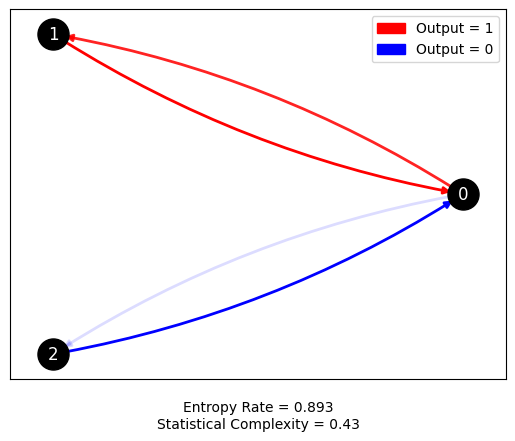

In [426]:
# neven process
transition_function = {'00':2, '01':1, '10':0, '11':0, '20':0}
fsm = FiniteStateMachine(states=[0,1,2], transition_function=transition_function)
fsm.calculate_emmision_0_probs()
fsm.calculate_transition_matrix()
fsm.calculate_entropy_and_complexity()
fsm.plot_from_transition_matrix()

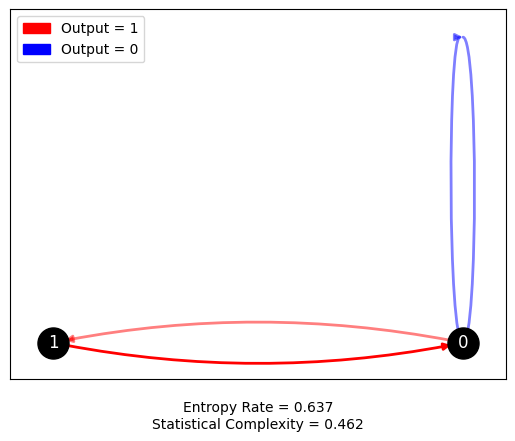

In [427]:
# even process
transition_function = {'00':0, '11':0, '01':1}
emission_0_probs = np.array([.5, 0])
fsm = FiniteStateMachine(states=[0,1], transition_function=transition_function,
                         emmision_0_probs=emission_0_probs)
fsm.calculate_transition_matrix()
fsm.calculate_entropy_and_complexity()
fsm.plot_from_transition_matrix()

[1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0]

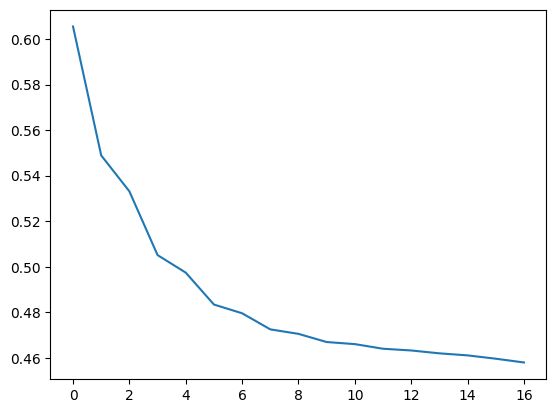

In [415]:
plt.plot(np.diff(fsm.compute_block_entropy(18, time_steps = 500000)))